In [153]:
from functools import partial
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
import jax.random as jr
import jaxopt

# JAX Tutorial: From Zero to Newbie

This tutorial will guide you from zero JAX knowledge to a beginner level. It assumes only basic Python and some familiarity with NumPy or PyTorch.

## The numpy API

``jax.numpy``, or ``jnp`` for friends, is the best entry point for new JAX users. It feels a lot like ordinary numpy!

In [154]:
a = jnp.ones((2))
b = jnp.array([1.0, 2.0])
a + b

Array([2., 3.], dtype=float32)

In [155]:
jnp.sin(a**2 + b**2) # really feels like numpy so far!

Array([ 0.9092974, -0.9589243], dtype=float32)

There are some differences though! For instance, JAX arrays are *immutable*.

In [156]:
# this would work in ordinary numpy, but throws an error in jax.numpy
# a[1] = 2.0 

In [157]:
# In JAX, we need the following syntax to achieve a *similar* result:
a = a.at[1].set(2.0)
a

Array([1., 2.], dtype=float32)

Actually, in the code block above, we did not really modify the existing array. Rather, we built a *new* array and assigned it to the variable ``a``.

The JAX interface for random number is also slighlt different for reasons that will be clear later on. Let us stick with ordinary numpy (``onp`` here) for now...

In [158]:
c = onp.random.randn((2))

We use ``c`` to showcase ordinary NumPy-JAX interoperability!

In [159]:
a + c

Array([3.3634915, 1.3936464], dtype=float32)

## Functional programming and pure functions

To get the most out of JAX, you should get used to a **functional programming** paradigm. In a nutshell, this means you should define your model, loss, etc. as *pure functions*. 

In software, a pure function produces an output that only depends on the function arguments (and not, for instance, on other global variables) and whose only effect is to generate an output. Pure functions have no *side-effects*, i.e. they do not modify global variables, print to the console, write to disk, etc. If you call a pure function twice with the same arguments, you are guaranteed to get the exact same result.

The following ``linear_model`` is a pure function. The returned output ``y``  only depends on the function arguments ``params`` and ``x``, and the function has no side-effects:

In [160]:
# A linear model as a pure function
def linear_model(params, x):
    y = x * params[0] + params[1]
    return y

In [161]:
y = linear_model(jnp.array([1.0, 2.0]), jnp.array([1.0])); y

Array([3.], dtype=float32)

For the sake of illustration, an example of non-pure function is given below:

In [162]:
# Similar to linear_model, but with side-effects
z  = jnp.array([0.0])
def non_pure_function(params, x):
    y = x * params[0] + params[1]
    y = y + z # the function output depends on a global variable z. Not allowed in pure functions!
    z = z + 1 # this modifies the global variable z, which is also side-effect!
    print("This is not a pure function, printing is also a side-effect!")
    return y 

While the (pure) functional programming paradigm may seem limiting, it is expressive enough and allows for significant optimization by the just-in-time compiler. Furthermore, as we will see in this tutorial, JAX provides powerful transformations that are well-defined for pure functions. Finally, the functional paradigm is close to how we think in math!

## Automatic differentiation and optimization

We illustrate automatic differentiation with the ``linear_model`` introduced above to illustrate pure functions and re-defined below:

In [163]:
# A linear model as a pure function
def linear_model(params, x):
    y = x * params[0] + params[1]
    return y

In [164]:
params_true = jnp.array([1.0, 2.0]) # true, unknown value
params_init = onp.random.randn(2,) # initial guess (initialized with ordinary numpy, we still dont know random numbers in JAX)

Let us generate some fake data taking ``true_param`` as true parameters

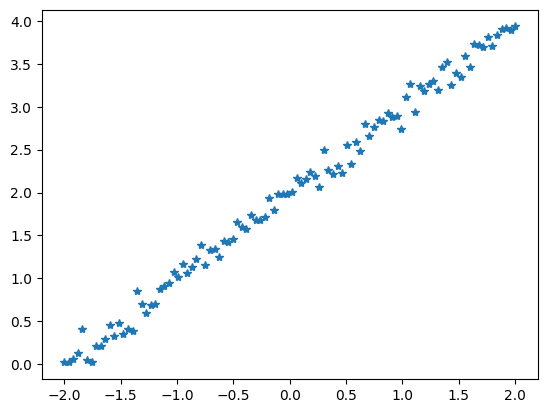

In [165]:
N = 100
x = jnp.linspace(-2, 2, 100)
y = linear_model(params_true, x) + onp.random.randn(N) * 0.1
plt.plot(x, y, "*");

Let us define the loss as a differentiable (pure) function

In [166]:
def loss_fn(p, y, x):
    y_hat = linear_model(p, x)
    loss = jnp.mean((y - y_hat) ** 2)
    return loss


loss_fn(params_init, y, x)

Array(10.914609, dtype=float32)

The ``jax.grad`` transfomation takes in a pure function and returns the *gradient* function. Exactly what we need to get the loss gradient!

In [167]:
loss_grad_fn = jax.grad(loss_fn) # by defaul, gradient wrt first argument (p)

In [168]:
loss_grad_fn(params_init, y, x) # calling the gradient function with some data, we get the gradient value!

Array([-5.2885237, -4.8015585], dtype=float32)

We can now set up a basic gradient-based optimization procedure!

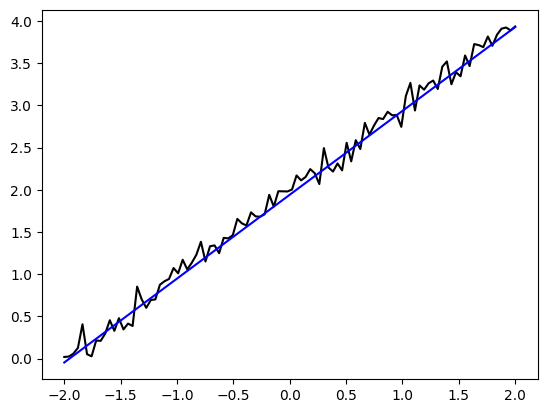

In [169]:
params_opt = params_init

lr = 1e-2
for _ in range(200):
    g = loss_grad_fn(params_opt, y, x)
    params_opt = params_opt - lr * g

plt.figure()
plt.plot(x, y, "k")
plt.plot(x, linear_model(params_opt, x), "b")

In [170]:
params_opt, params_true  # almost there...

(Array([0.9935685, 1.9416286], dtype=float32), Array([1., 2.], dtype=float32))

Traditional second-order solvers are also available in external libraries such as ``jaxopt``!

In [171]:
# BFGS
solver_bfgs = jaxopt.BFGS(fun=partial(loss_fn, y=y, x=x))
params_bfgs, state_bfgs = solver_bfgs.run(params_init)
params_bfgs

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 25.25472068786621 Stepsize:1.0  Decrease Error:10.081286430358887  Curvature Error:25.25472068786621 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.4175429940223694  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.6263145208358765  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.9394717812538147  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 


Array([1.0013831, 1.9838532], dtype=float32)

In [172]:
# Levenberg-Marquardt
def resid_fn(p, y, x):
    y_hat = linear_model(p, x)
    resid = y - y_hat
    return resid


solver_lm = jaxopt.LevenbergMarquardt(lambda p: resid_fn(p, y, x), maxiter=100)
params_lm, state_lm = solver_lm.run(params_init)
params_lm

Array([1.0013812, 1.9838496], dtype=float32)

# Parallel execution with vmap

JAX provides a powerful ``vmap`` operator to *vectorize* function execution

In [173]:
# Let us build a model that acts on a single element.
def linear_model(weight, input):
    return weight @ input


in_feat = 3
out_feat = 10

W = onp.random.randn(out_feat, in_feat)  # 10 outputs, 3 inputs
x = onp.random.randn(in_feat)
y = linear_model(W, x)

# What if we have a vector of examples?
batch_size = 32
X = onp.random.randn(batch_size, in_feat)

# In pytorch, we would end up re-writing the linear layer in a less straightforward fashion:
Y = X @ W.T # :-(
Y.shape

# In jax, we would rather harness the power of vmap!
Y_vmap = jax.vmap(linear_model, in_axes=(None, 0))(W, X) # :-)
jnp.allclose(Y, Y_vmap, rtol=1e-4) # equivalent up to some numerical difference

Array(True, dtype=bool)

In [174]:
# Here (like above), we vectorize on the second argument only (the data)
# This makes sense when we apply the same model to different data batches
batched_linear_model = jax.vmap(linear_model, in_axes=(None, 0))
Y_vmap = batched_linear_model(W, X)

In [175]:
# This is the converse: different models (an ensemble?) acting on the same data!
W_many = onp.random.randn(batch_size, out_feat, in_feat)
many_linear_models_same_data = jax.vmap(linear_model, in_axes=(0, None))
Y_many = many_linear_models_same_data(W_many, x)
Y_many.shape

(32, 10)

In [176]:
# By default, we vectorize on all arguments. We simulate several models over several datasets in parallel!
many_linear_models = jax.vmap(linear_model)
Y_many = many_linear_models(W_many, X)

# JAX data structure: PyTrees 

In JAX, function arguments can be (nested) collection objects generically referred to as PyTrees. This simplifies the definition of structured models such as neural networks from scratch.

Example: MLP with one hidden layer, parameters organized in a nested python dictionary

In [177]:
# Let us implement a MLP from scratch!
nn_sizes = [3, 16, 10]  # 3 inputs, 16 hidden layers, 10 outputs

params_nn = {
    "layer0": {
        "W": onp.random.randn(nn_sizes[1], nn_sizes[0]),
        "b": onp.random.randn(nn_sizes[1]),
    },
    "layer1": {
        "W": onp.random.randn(nn_sizes[2], nn_sizes[1]),
        "b": onp.random.randn(nn_sizes[2]),
    },
}

def nn_model(p, input):
    z = jax.nn.sigmoid(p["layer0"]["W"] @ input + p["layer0"]["b"])
    out = p["layer1"]["W"] @ z + p["layer1"]["b"]
    return out

In [178]:
x = onp.random.randn(
    nn_sizes[0],
)
y_nn = nn_model(params_nn, x)
y_nn.shape

(10,)

In [179]:
# batched execution of the MLP with vmap
X = onp.random.randn(batch_size, nn_sizes[0])
Y = jax.vmap(nn_model, in_axes=(None, 0))(params_nn, X)
Y.shape

(32, 10)

In [180]:
# batched loss computation
def loss_fn(p, input, target):
    predicted = jax.vmap(nn_model, in_axes=(None, 0))(p, input)
    error = target - predicted
    return jnp.mean(error**2)

Y_true = onp.random.randn(batch_size, nn_sizes[-1]) # some fake data
loss_fn(params_nn, X, Y_true)

Array(11.065194, dtype=float32)

JAX has built-in tools for PyTree manipulation

In [181]:
params_sq = jax.tree.map(lambda x : x**2, params_nn) # all parameters squared (unary op)

In [182]:
params_sum = jax.tree.map(lambda x, y: x + y, params_nn, params_sq) # sum of two pytrees (binary op)

In [183]:
#params_flat, unflatten_pars = jax.flatten_util.ravel_pytree(params_nn) # flat vector, unflatten function

# JAX as a just-in-time compiled language

JAX functions can be jit-compiled for much faster execution. Common use case: compile gradient computations!

In [184]:
%%timeit -n 100
loss, grad = jax.value_and_grad(loss_fn)(params_nn, X, Y)

2 ms ± 72.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [185]:
grad_fn_jit = jax.jit(jax.value_and_grad(loss_fn))

In [186]:
%%timeit -n 1000
loss, grad = grad_fn_jit(params_nn, X, Y)

66.1 μs ± 30.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Random numbers in JAX

Native JAX random number generators always require a key to be passed explicitly

In [187]:
key = jr.key(1234)

In [188]:
jr.normal(key)

Array(1.1031016, dtype=float32)

In [189]:
jr.normal(key, shape=(2,)) # same key=same result! It's a pure function.

Array([1.1031016 , 0.86306226], dtype=float32)

The JAX user is responsible of splitting the keys to generate different random numbers

In [190]:
key, subkey = jr.split(key, 2)
jr.normal(key, shape=(2,)), jr.normal(subkey, shape=(2,))

(Array([-0.95239824,  0.34621808], dtype=float32),
 Array([ 1.4983746, -1.4730613], dtype=float32))

This is a price to pay for having a functional interface!

In [191]:
# same arguments, different results. The random.randn in ordinary numpy is not a pure function!
onp.random.randn(2), onp.random.randn(2)

(array([-0.29626917, -0.46805604]), array([-0.4217497 ,  1.99345808]))

In [192]:
# same arguments, same results. This is a pure function!
jr.normal(key, shape=(2,)), jr.normal(key, shape=(2,))

(Array([-0.95239824,  0.34621808], dtype=float32),
 Array([-0.95239824,  0.34621808], dtype=float32))

# Higher-level interfaces: flax.linen

There are many neural network libraries built upon JAX.
Let us quickly explore ``flax.linen``

In [193]:
from flax import linen as nn

In [194]:
in_size = 10
out_size = 5
hidden = 16

class CustomRNNCell(nn.Module):
    hidden_size: int
    out_size: int

    def setup(self):
        self.lin1 = nn.Dense(self.hidden_size)
        self.lin2 = nn.Dense(self.out_size)

    def __call__(self, input):
        x = nn.relu(self.lin1(input))
        x = self.lin2(x)
        return x

f_xu = CustomRNNCell(hidden_size=hidden, out_size=out_size)
key, subkey = jr.split(key, 2)

# Warning for PyTorch users: params are not part of the module!
params = f_xu.init(subkey, jnp.ones((in_size)))
params

{'params': {'lin1': {'kernel': Array([[-0.0607008 , -0.56247073, -0.09260884,  0.25199047,  0.31163484,
            0.28304234,  0.07770133, -0.0202711 , -0.31896597, -0.597906  ,
            0.24707334,  0.14779164,  0.2850042 , -0.096579  , -0.04123046,
            0.12406826],
          [-0.1729729 , -0.09013411,  0.42306283,  0.08203582, -0.19639806,
            0.45139998, -0.18776187, -0.07141428,  0.5587324 ,  0.6307393 ,
            0.13413444, -0.21675588, -0.08671422,  0.13085195, -0.29311076,
           -0.09388349],
          [ 0.27336782,  0.23662308, -0.04149418, -0.35115185,  0.40033054,
            0.16252317, -0.10901854,  0.2992458 ,  0.09969153,  0.6846909 ,
           -0.10740535, -0.20036739, -0.21421935, -0.3843265 ,  0.24596885,
            0.14136258],
          [-0.3164381 ,  0.14398937, -0.41121867,  0.02435028,  0.24094355,
           -0.25838664,  0.23570947, -0.20689772,  0.23262039, -0.08316714,
            0.1711468 , -0.0081827 ,  0.27201268,  0.24199094

In [195]:
# Indeed, to use the model, we pass the parameters as first argument or the apply method!
f_xu.apply(params, jnp.ones(in_size))

Array([-0.48732084, -0.5086825 ,  1.5485504 ,  1.1163081 , -0.729933  ],      dtype=float32)

# Scan

The ``jax.lax.scan`` transform makes certain loop unrolling blazing fast. Roughly, it correspond to the plain Python code:


```python
def scan(f, init, xs, length=None):
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```

However, ``jax.lax.scan`` is highly optimized. My typical use case: speed up custom recurrent neural network/state-space models


\begin{align*}
 x_{k+1} &= N_f(x_k, u_k)\\
 y_k &= N_g(x_k),
\end{align*}
where $N_f$, $N_g$ are some custom-made neural networks. Here is an example

In [196]:
nx = 4
ny = 3
nu = 2
seq_len = 100

In [197]:
x0 = jnp.ones(nx) # initial state
u0 = jnp.ones(nu) # initial input (just to simulate the first step)
u = jnp.ones((seq_len, nu)) # input sequence

In [198]:
class CustomRNNCell(nn.Module):
    nx: int # state size
    ny: int # output size 
    hidden_size: int

    def setup(self):
        # blocks of f(x, u)
        self.fxu_lin1 = nn.Dense(self.hidden_size)
        self.fxu_lin2 = nn.Dense(self.nx)
        # blocks of g(x)
        self.gx_lin1 = nn.Dense(self.hidden_size)
        self.gx_lin2 = nn.Dense(self.ny)

    def __call__(self, x, u):
        
        x_new = nn.relu(self.fxu_lin1(jnp.concatenate([x, u], axis=-1)))
        x_new = self.fxu_lin2(x_new)

        y = nn.relu(self.gx_lin1(x))
        y = self.gx_lin2(y)
        return x_new, y


In [199]:
rnn_cell = CustomRNNCell(nx, ny, hidden_size=32)
key, subkey = jr.split(key, 2)
rnn_params = rnn_cell.init(subkey, x0, u0)

In [200]:
# simulate the first step
x1, y1 = rnn_cell.apply(rnn_params, x0, u0)
x1, y1

(Array([ 0.3038781 , -0.5354821 ,  0.901162  , -0.15403043], dtype=float32),
 Array([-0.7041999 , -0.3049767 ,  0.21753308], dtype=float32))

In [201]:
# simulate the sequence
fg_func = lambda x, u: rnn_cell.apply(rnn_params, x, u) 
xf, y = jax.lax.scan(fg_func, x0, u)
xf.shape, y.shape

((4,), (100, 3))

In [202]:
# a minimal interface for the RNN
def simulate_rnn(params, x0, u):
    fg_func = lambda x, u: rnn_cell.apply(params, x, u)
    xf, y = jax.lax.scan(fg_func, x0, u)
    return xf, y

xf, y = simulate_rnn(rnn_params, x0, u)

All JAX transformsations are composable. You can *batchify* the `simulate_rnn` function above with ``vmap`` and make it super efficient with ``jit``!

See the [system identifitation example](gallery/system_identification/system_identification.ipynb) in the gallery!